In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.insert(0,'..')
import xbrl.envs.hlsutils as hlsutils
from celluloid import Camera

narms = 5
mu_1 = 1.0
mu_2 = 0.8
mu_3 = 1.2
radius = 0.5

def quadrant(x):
    if x[0] >= 0 and x[1] >= 0:
        return 1
    elif x[0] < 0 and x[1] >= 0:
        return 2
    elif x[0] < 0 and x[1] < 0:
        return 3
    else: 
        return 4

def reward(x, a):
    r = np.zeros(5)
    r[0] = mu_1
    r[1:5] = mu_2
    
    if np.linalg.norm(x) > radius:
        r[quadrant(x)] = mu_3

    return r[a]

def rand_context():
    rho = np.random.rand()
    angle = np.random.rand() * 2 * np.pi
    return np.array([np.cos(angle), np.sin(angle)]) * rho

def opt_arm(x):
    return quadrant(x) if np.linalg.norm(x) > radius else 0

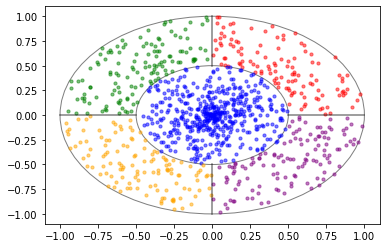

In [2]:
def plot_wheel(n_contexts=1000):
    fig, ax = plt.subplots()
    plt.plot([-1,-0.5],[0,0], color="black", alpha=0.5)
    plt.plot([0.5,1],[0,0], color="black", alpha=0.5)
    plt.plot([0,0],[-1,-0.5], color="black", alpha=0.5)
    plt.plot([0,0],[0.5,1], color="black", alpha=0.5)
    c1 = plt.Circle((0, 0), 1, color='black', fill=False, alpha=0.5)
    c2 = plt.Circle((0, 0), 0.5, color='black', fill=False, alpha=0.5)
    ax.add_patch(c1)
    ax.add_patch(c2)
    colors = {1: "red", 2: "green", 3:"orange", 4:"purple"}
    for i in range(n_contexts):
        x = rand_context()
        if np.linalg.norm(x) > radius:
            plt.scatter(x[0],x[1],c=colors[quadrant(x)],s=10,alpha=0.5)
        else:
            plt.scatter(x[0],x[1],c="blue",s=10,alpha=0.5)
    plt.show()

plot_wheel()

In [3]:
def phi_1(x,a):
    vec = np.zeros(4)
    vec[0] = a == 0
    vec[1] = a != 0 and np.linalg.norm(x) <= radius
    vec[2] = a != 0 and np.linalg.norm(x) > radius and quadrant(x) == a
    vec[3] = a != 0 and np.linalg.norm(x) > radius and quadrant(x) != a
    return vec.astype(int)

theta_1 = np.array([mu_1, mu_2, mu_3, mu_2])

def phi_2(x,a):
    vec = np.zeros(3)
    vec[0] = a == 0
    vec[1] = a != 0 and (np.linalg.norm(x) <= radius or np.linalg.norm(x) > radius and quadrant(x) != a)
    vec[2] = a != 0 and np.linalg.norm(x) > radius and quadrant(x) == a
    return vec.astype(int)

theta_2 = np.array([mu_1, mu_2, mu_3])

def phi_3(x,a):
    vec = np.zeros(3)
    vec[0] = reward(x,a)
    vec[1] = x[0]
    vec[2] = x[1]
    return vec

theta_3 = np.array([1,0,0])

def phi_4(x,a):
    vec = np.zeros(3)
    vec[0] = reward(x,a)
    vec[1] = 1 if x[0] >= 0 else -1
    vec[2] = 1 if x[1] >= 0 else -1
    return vec

theta_4 = np.array([1,0,0])

def phi_5(x,a):
    vec = np.zeros(3)
    vec[0] = reward(x,a)
    vec[1] = np.cos(4 * np.pi * x[0] * (a+1))
    vec[2] = np.sin(4 * np.pi * x[1] * (a+1))
    return vec

theta_5 = np.array([1,0,0])


In [4]:
def build_features(phi, theta, ncontexts):
    dim = theta.size

    features = np.zeros((ncontexts, narms, dim))
    rewards = np.zeros((ncontexts, narms))

    # test realizability
    for i in range(ncontexts):
        x = rand_context()
        for a in range(5):
            assert reward(x,a) == phi(x,a).dot(theta)
            # print(x, a, reward(x,a), phi(x,a).dot(theta))
            rewards[i,a] = reward(x,a)
            features[i,a,:] = phi(x,a)

    print("Realizable representation!")

    # build feature matrix

    print(f"HLS rank: {hlsutils.hls_rank(features, rewards)} / {features.shape[2]}")
    print(f"is HLS: {hlsutils.is_hls(features, rewards)}")
    print(f"HLS min eig: {hlsutils.hls_lambda(features, rewards)}")
    print(f"HLS rank: {hlsutils.hls_rank(features, rewards)}")
    print(f"is CMB: {hlsutils.is_cmb(features, rewards)}")
    print()

    return features, rewards

build_features(phi_1, theta_1, 100)
build_features(phi_2, theta_2, 100)
build_features(phi_3, theta_3, 100)
build_features(phi_4, theta_4, 100)
print()

Realizable representation!
HLS rank: 2 / 4
is HLS: False
HLS min eig: 0.0
HLS rank: 2
is CMB: False

Realizable representation!
HLS rank: 2 / 3
is HLS: False
HLS min eig: 0.0
HLS rank: 2
is CMB: False

Realizable representation!
HLS rank: 3 / 3
is HLS: True
HLS min eig: 0.15022409281602894
HLS rank: 3
is CMB: True

Realizable representation!
HLS rank: 3 / 3
is HLS: True
HLS min eig: 0.971813683600853
HLS rank: 3
is CMB: True




In [5]:
def egreedy_fake(phi, dim, V_inv, theta, x, t):
    return np.random.randint(5) if np.random.rand() < 1 / np.sqrt(t+1) else opt_arm(x)

def linucb(phi, dim, V_inv, theta, x, t):
    ff = np.array([phi(x,a) for a in range(narms)])
    conf = np.sqrt((np.matmul(ff, V_inv) * ff).sum(axis=1)) * beta(t, dim)
    ucbs = ff.dot(theta) + conf + np.random.randn() * 1e-15
    return np.argmax(ucbs)

def beta(t, dim):
    return max(np.sqrt(dim * np.log(t+1)), 1)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21


KeyboardInterrupt: 

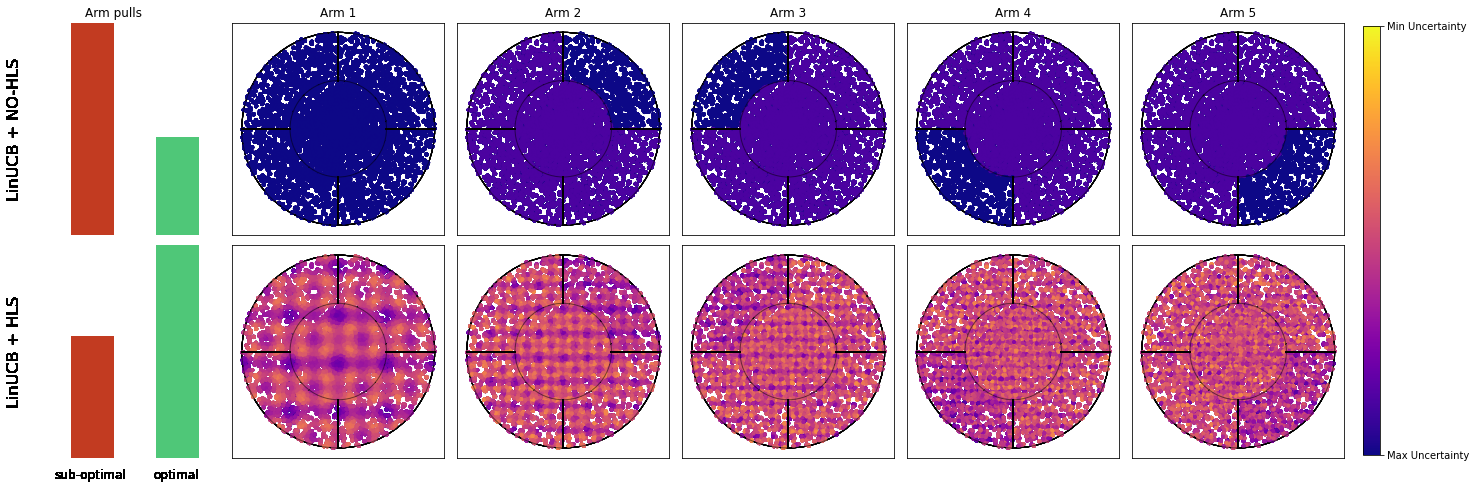

In [6]:
plot_every = 1
T = 200
ncontexts = 5000
rhos = np.random.rand(ncontexts)
angles = np.random.rand(ncontexts) * 2 * np.pi
eval_contexts = np.array([np.cos(angles), np.sin(angles)]).T * rhos[:, np.newaxis]

# algos = [(egreedy_fake, phi_2, 3), (egreedy_fake, phi_3, 3)]
# names = ["EpsGreedy + NO-HLS", "EpsGreedy + HLS"]
algos = [(linucb, phi_2, 3), (linucb, phi_5, 3)]
names = ["LinUCB + NO-HLS", "LinUCB + HLS"]

n_algos = len(algos)

feats = []
Vs = []
Vinvs = []
thetas = []
sum_rews = []
n_opt = [0 for _ in algos]
max_vals = [0 for _ in algos]
for i, algo in enumerate(algos):
    _, phi, dim = algo
    ff = np.zeros((ncontexts, narms, dim))
    for i in range(ncontexts):
        for a in range(5):
            ff[i,a,:] = phi(eval_contexts[i],a)
    feats.append(ff)
    Vs.append(np.eye(dim))
    Vinvs.append(np.eye(dim))
    thetas.append(np.zeros(dim))
    sum_rews.append(np.zeros(dim))

fig, ax = plt.subplots(n_algos,6, figsize=(24,4*n_algos))

# fig.subplots_adjust(right=0.9)

plt.subplots_adjust(wspace=0.05, 
                    hspace=0.05)

cbar_ax = fig.add_axes([0.91, 0.13, 0.01, 0.745])
for i in range(n_algos):
    if i == 0:
        ax[i,0].set_title("Arm pulls")
    ax[i,0].axes.xaxis.set_visible(False)
    ax[i,0].axes.yaxis.set_visible(False)
    ax[i,0].set_aspect('equal')
    ax[i,0].axis("off")
    for k in range(5):
        if i == 0:
            ax[i,k+1].set_title("Arm {}".format(k+1))
        ax[i,k+1].axes.xaxis.set_visible(False)
        ax[i,k+1].axes.yaxis.set_visible(False)
        ax[i,k+1].set_aspect('equal')

camera = Camera(fig)

for t in range(T):
    print(t)
    x = rand_context()
    for idx, algo in enumerate(algos):
        # play arm
        algo_fn, phi, dim = algo
        arm = algo_fn(phi, dim, Vinvs[idx], thetas[idx], x, t)
        n_opt[idx] += 1 if arm == opt_arm(x) else 0
        rew = reward(x,arm) + np.random.randn()

        # update stats
        Vs[idx] += np.outer(phi(x,arm), phi(x,arm))
        Vinvs[idx] = np.linalg.inv(Vs[idx])
        sum_rews[idx] += phi(x,arm) * rew
        thetas[idx] = Vinvs[idx].dot(sum_rews[idx])

        if t % plot_every == 0:
            confs = np.zeros((ncontexts, narms))
            for a in range(narms):
                confs[:, a] = np.sqrt((np.matmul(feats[idx][:,a,:], Vinvs[idx]) * feats[idx][:,a,:]).sum(axis=1)) * beta(t, dim)

            if t == 0:
                max_vals[idx] = confs.max()
            confs /= max_vals[idx]

            # plot
            for k in range(5):
                sc = ax[idx, k+1].scatter(eval_contexts[:,0],eval_contexts[:,1], c=-confs[:,k], vmin=-1, vmax=0, s=10, cmap="plasma")

                ax[idx, k+1].plot([-1,-0.5],[0,0], color="black", alpha=0.5)
                ax[idx, k+1].plot([0.5,1],[0,0], color="black", alpha=0.5)
                ax[idx, k+1].plot([0,0],[-1,-0.5], color="black", alpha=0.5)
                ax[idx, k+1].plot([0,0],[0.5,1], color="black", alpha=0.5)
                c1 = plt.Circle((0, 0), 1, color='black', fill=False, alpha=0.5)
                c2 = plt.Circle((0, 0), 0.5, color='black', fill=False, alpha=0.5)
                ax[idx, k+1].add_patch(c1)
                ax[idx, k+1].add_patch(c2)

                rect_sub = plt.Rectangle((0.3, 0), 0.2, (t+1-n_opt[idx]) / (t+1), linewidth=1, edgecolor=[0.76, 0.23, 0.13], facecolor=[0.76, 0.23, 0.13])
                ax[idx, 0].add_patch(rect_sub)
                rect_opt = plt.Rectangle((0.7, 0), 0.2, n_opt[idx] / (t+1), linewidth=1, edgecolor=[0.31, 0.78, 0.47], facecolor=[0.31, 0.78, 0.47])
                ax[idx, 0].add_patch(rect_opt)
                if idx == n_algos - 1:
                    ax[idx, 0].text(0.22, -0.1, "sub-optimal", fontsize=12)
                    ax[idx, 0].text(0.69, -0.1, "optimal", fontsize=12)

                ax[idx, 0].text(0, 0.5, names[idx], rotation=90, va='center', fontsize=16)
            
            cbar = fig.colorbar(sc, cax=cbar_ax, ticks=[-1,0])
            cbar.ax.set_yticklabels(["Max Uncertainty", "Min Uncertainty"])
    
    if t % plot_every == 0:
        camera.snap()

animation = camera.animate()
animation.save('wheel.mp4')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

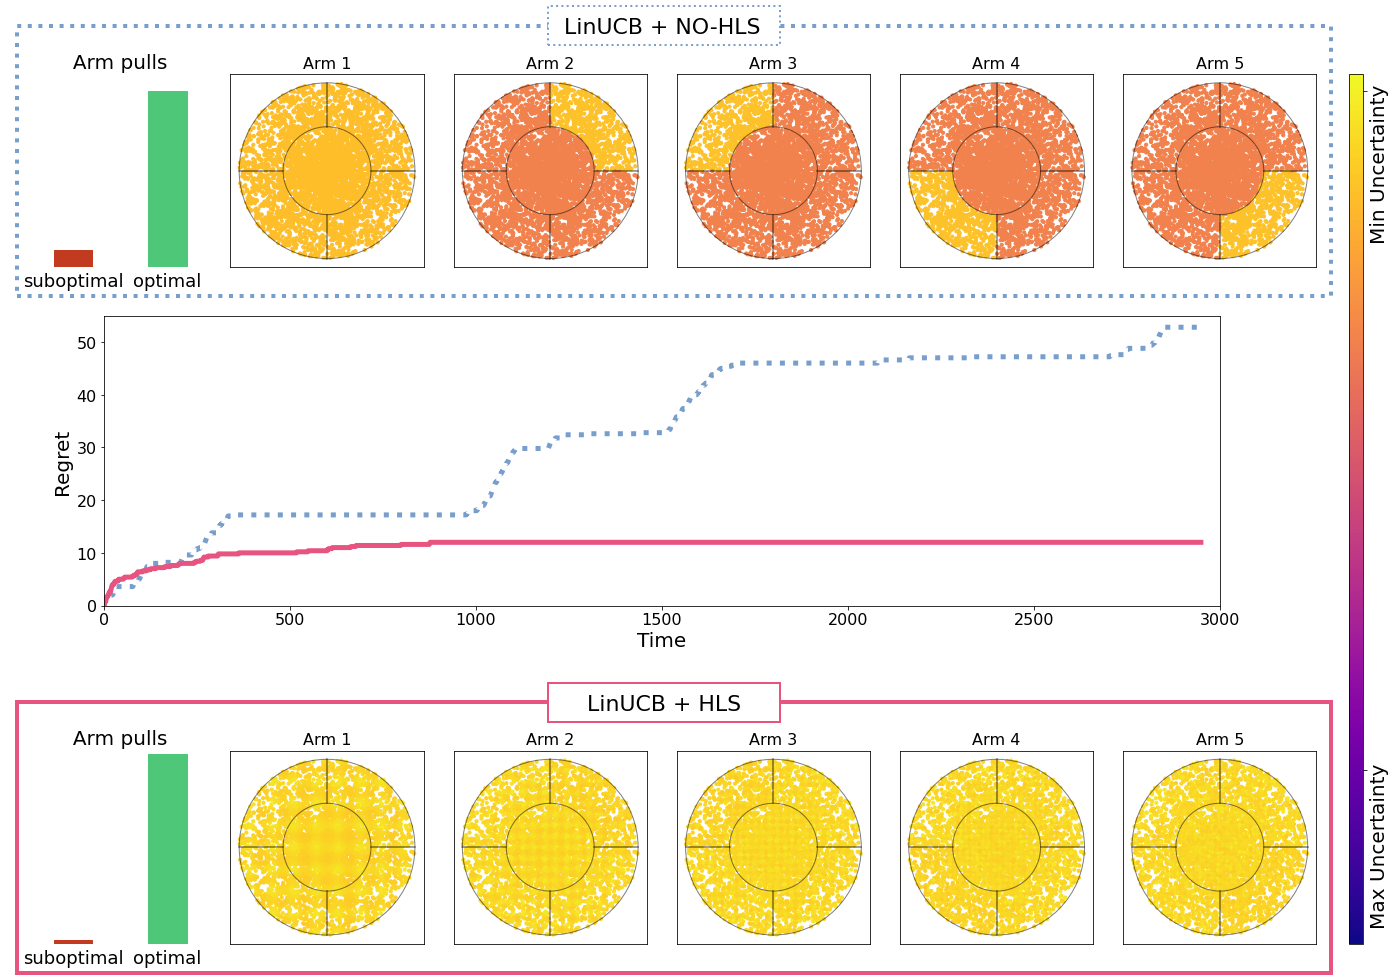

In [71]:
np.random.seed(123)

plot_every = 5
T = 3000 # 3000
ncontexts = 5000
rhos = np.random.rand(ncontexts)
angles = np.random.rand(ncontexts) * 2 * np.pi
eval_contexts = np.array([np.cos(angles), np.sin(angles)]).T * rhos[:, np.newaxis]

# algos = [(egreedy_fake, phi_2, 3), (egreedy_fake, phi_5, 3)]
# names = ["EpsGreedy + NO-HLS", "EpsGreedy + HLS"]
algos = [(linucb, phi_2, 3), (linucb, phi_5, 3)]
names = ["LinUCB + NO-HLS", "LinUCB + HLS"]
colors = [[0.47, 0.62, 0.8], [0.91, 0.33, 0.5]]
linestyle = [':', '-']

n_algos = len(algos)
assert n_algos == 2 # the following only works for 2 algorithms

feats = []
Vs = []
Vinvs = []
thetas = []
sum_rews = []
n_opt = [0 for _ in algos]
max_vals = [0 for _ in algos]
times = np.arange(T)
regrets = [np.zeros(T) for _ in algos]
for i, algo in enumerate(algos):
    _, phi, dim = algo
    ff = np.zeros((ncontexts, narms, dim))
    for i in range(ncontexts):
        for a in range(5):
            ff[i,a,:] = phi(eval_contexts[i],a)
    feats.append(ff)
    Vs.append(np.eye(dim))
    Vinvs.append(np.eye(dim))
    thetas.append(np.zeros(dim))
    sum_rews.append(np.zeros(dim))

fig = plt.figure(figsize=(24,16))
layout = [
          ["Conf L1", "Conf L1", "Conf L2", "Conf L2", "Conf L3", "Conf L3", "Conf L4", "Conf L4", "Conf L5", "Conf L5", "Conf L6", "Conf L6"],
          ["Conf L1", "Conf L1", "Conf L2", "Conf L2", "Conf L3", "Conf L3", "Conf L4", "Conf L4", "Conf L5", "Conf L5", "Conf L6", "Conf L6"],
          ["Conf L1", "Conf L1", "Conf L2", "Conf L2", "Conf L3", "Conf L3", "Conf L4", "Conf L4", "Conf L5", "Conf L5", "Conf L6", "Conf L6"],
          ["Conf L1", "Conf L1", "Conf L2", "Conf L2", "Conf L3", "Conf L3", "Conf L4", "Conf L4", "Conf L5", "Conf L5", "Conf L6", "Conf L6"],
          [None] * 12,
          [None, "Regret", "Regret", "Regret", "Regret", "Regret", "Regret", "Regret", "Regret", "Regret", "Regret", None],
          [None, "Regret", "Regret", "Regret", "Regret", "Regret", "Regret", "Regret", "Regret", "Regret", "Regret", None],
          [None, "Regret", "Regret", "Regret", "Regret", "Regret", "Regret", "Regret", "Regret", "Regret", "Regret", None],
          [None, "Regret", "Regret", "Regret", "Regret", "Regret", "Regret", "Regret", "Regret", "Regret", "Regret", None],
          [None, "Regret", "Regret", "Regret", "Regret", "Regret", "Regret", "Regret", "Regret", "Regret", "Regret", None],
          [None, "Regret", "Regret", "Regret", "Regret", "Regret", "Regret", "Regret", "Regret", "Regret", "Regret", None],
          [None] * 12,
          [None] * 12,
          [None] * 12,
          ["Conf R1", "Conf R1", "Conf R2", "Conf R2", "Conf R3", "Conf R3", "Conf R4", "Conf R4", "Conf R5", "Conf R5", "Conf R6", "Conf R6"],
          ["Conf R1", "Conf R1", "Conf R2", "Conf R2", "Conf R3", "Conf R3", "Conf R4", "Conf R4", "Conf R5", "Conf R5", "Conf R6", "Conf R6"],
          ["Conf R1", "Conf R1", "Conf R2", "Conf R2", "Conf R3", "Conf R3", "Conf R4", "Conf R4", "Conf R5", "Conf R5", "Conf R6", "Conf R6"],
          ["Conf R1", "Conf R1", "Conf R2", "Conf R2", "Conf R3", "Conf R3", "Conf R4", "Conf R4", "Conf R5", "Conf R5", "Conf R6", "Conf R6"]
          ]
axd = fig.subplot_mosaic(layout, empty_sentinel=None)

cbar_ax = fig.add_axes([0.91, 0.125, 0.008, 0.755])

axis_to_data = axd["Regret"].transAxes + axd["Regret"].transData.inverted()
data_to_axis = axis_to_data.inverted()

axd["Regret"].set_xlabel("Time", fontsize=20)
axd["Regret"].set_ylabel("Regret", fontsize=20)
axd["Regret"].set_xlim([0, T])
axd["Regret"].set_ylim([0, 55])
axd["Regret"].tick_params(axis="x", labelsize=16)
axd["Regret"].tick_params(axis="y", labelsize=16)

plt.subplots_adjust(wspace=0, hspace=0)

axd["Conf L1"].set_title("     Arm pulls", fontsize=20)
axd["Conf R1"].set_title("     Arm pulls", fontsize=20)
for p in ["L", "R"]:
    axd["Conf {0}1".format(p)].axis("off")
    for k in range(6):
        axd["Conf {0}{1}".format(p,k+1)].axes.xaxis.set_visible(False)
        axd["Conf {0}{1}".format(p,k+1)].axes.yaxis.set_visible(False)
        axd["Conf {0}{1}".format(p,k+1)].set_aspect('equal')
        if k > 0:
            axd["Conf {0}{1}".format(p,k+1)].set_title("Arm {}".format(k), fontsize=16)

camera = Camera(fig)

for t in range(T):
    plot_every = 1 if t <= 100 else (2 if t<= 500 else (10 if t<= 1500 else 50))
    print(t)
    x = rand_context()
    for idx, algo in enumerate(algos):
        # play arm
        algo_fn, phi, dim = algo
        arm = algo_fn(phi, dim, Vinvs[idx], thetas[idx], x, t)
        n_opt[idx] += 1 if arm == opt_arm(x) else 0
        rew = reward(x,arm) + np.random.randn()

        # update stats
        Vs[idx] += np.outer(phi(x,arm), phi(x,arm))
        Vinvs[idx] = np.linalg.inv(Vs[idx])
        sum_rews[idx] += phi(x,arm) * rew
        thetas[idx] = Vinvs[idx].dot(sum_rews[idx])
        regrets[idx][t:] += reward(x, opt_arm(x)) - reward(x,arm)

        if t % plot_every == 0:

            axd["Regret"].plot(times[:t], regrets[idx][:t], label=names[idx], color=colors[idx], linewidth=5, linestyle=linestyle[idx])

            # x_ax, y_ax = data_to_axis.transform((t, regrets[idx][t]))
            # start_x, start_y = x_ax - 0.1, y_ax - 0.1
            # dim_x, dim_y = axis_to_data.transform((start_x + 0.2, start_y + 0.2))
            # print(start_x, start_y, dim_x, dim_y)
            # rect = plt.Rectangle((start_x, start_y), dim_x, dim_y, linewidth=2, edgecolor="black", facecolor="none", clip_on=False)
            # axd["Regret"].add_patch(rect)

            confs = np.zeros((ncontexts, narms))
            for a in range(narms):
                confs[:, a] = np.sqrt((np.matmul(feats[idx][:,a,:], Vinvs[idx]) * feats[idx][:,a,:]).sum(axis=1)) * beta(t, dim)

            if t == 0:
                max_vals[idx] = confs.max()
            confs /= max_vals[idx]

            # plot
            p = "L" if idx == 0 else "R"
            for k in range(5):
                ax = axd["Conf {0}{1}".format(p,k+2)]
                sc = ax.scatter(eval_contexts[:,0],eval_contexts[:,1], c=-confs[:,k], vmin=-1, vmax=0, s=10, cmap="plasma")

                ax.plot([-1,-0.5],[0,0], color="black", alpha=0.5)
                ax.plot([0.5,1],[0,0], color="black", alpha=0.5)
                ax.plot([0,0],[-1,-0.5], color="black", alpha=0.5)
                ax.plot([0,0],[0.5,1], color="black", alpha=0.5)
                c1 = plt.Circle((0, 0), 1, color='black', fill=False, alpha=0.5)
                c2 = plt.Circle((0, 0), 0.5, color='black', fill=False, alpha=0.5)
                ax.add_patch(c1)
                ax.add_patch(c2)

            ax = axd["Conf {0}1".format(p)]
            rect_sub = plt.Rectangle((0.24, 0), 0.2, (t+1-n_opt[idx]) / (t+1), linewidth=1, edgecolor=[0.76, 0.23, 0.13], facecolor=[0.76, 0.23, 0.13])
            ax.add_patch(rect_sub)
            rect_opt = plt.Rectangle((0.73, 0), 0.2, n_opt[idx] / (t+1), linewidth=1, edgecolor=[0.31, 0.78, 0.47], facecolor=[0.31, 0.78, 0.47])
            ax.add_patch(rect_opt)
            ax.text(0.08, -0.1, "suboptimal", fontsize=18)
            ax.text(0.65, -0.1, "optimal", fontsize=18)
            
            cbar = fig.colorbar(sc, cax=cbar_ax, ticks=[-0.8,-0.02])
            cbar.ax.set_yticklabels(["Max Uncertainty", "Min Uncertainty"], fontsize=20, rotation=90)
    
    if t % plot_every == 0:
        rect = plt.Rectangle((0.05,-0.15), 6.8, 1.4, linewidth=4, linestyle=":", edgecolor=colors[0], facecolor="none", clip_on=False)
        axd["Conf L1"].add_patch(rect)
        rect = plt.Rectangle((2.8,1.15), 1.2, 0.2, linewidth=2, linestyle=":", edgecolor=colors[0], facecolor="white", clip_on=False)
        axd["Conf L1"].add_patch(rect)
        axd["Conf L1"].text(2.88, 1.21, names[0], fontsize=22)


        rect = plt.Rectangle((0.05,-0.15), 6.8, 1.4, linewidth=4, edgecolor=colors[1], facecolor="none", clip_on=False)
        axd["Conf R1"].add_patch(rect)
        rect = plt.Rectangle((2.8,1.15), 1.2, 0.2, linewidth=2, edgecolor=colors[1], facecolor="white", clip_on=False)
        axd["Conf R1"].add_patch(rect)
        axd["Conf R1"].text(3, 1.21, names[1], fontsize=22)

        camera.snap()

animation = camera.animate()
animation.save('wheel.mp4')